# An End-to-End Implementation of Gradient Descent for Linear Regression

> A manual implementation of the <a href="https://en.wikipedia.org/wiki/Gradient_descent">gradient descent algorithm</a> for <a href="https://en.wikipedia.org/wiki/Linear_regression">linear regression</a>.
- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- categories: [gradient-descent, linear-regression, ml-algorithm-from-scratch, machine-learning]

In [1]:
#hide
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#hide
sns.set_context("talk")

## Background

Gradient descent an algorithm for optimization of mathematical functions for which a derivative (or, more generally, gradient) exists at every point for which the function is defined. A derivative (or slope) is the rate of change of the output value of a function relative to its input. In order to optimize such an objective function, we want to minimize its rate of change (derivative). Graphically, we want to start at some point on a plotted curve of the function and move in a direction of decreasing derviative (slope) until it reaches zero (i.e. zero gradient). This is called gradient since we are descending along the curve for the gradient of the function, or going from a high gradient to a low (zero) value.

## Goal

Here, we will use Python to implement this algorithm from scratch. Then, we'll use it to perform multivariate linear regression on synthetic data and compare its performance and attributes to implementations provided by the `scikit-learn` Python library.

## Gradients

For implementing linear regression using gradient descent, we will aim to minimize the mean squared error (*MSE*) which is the squared difference between the true and predicted values of the dependent variable (`y`). In calculus, minimizing an objective function requires knowing when the derivative of that function goes to zero. That's exactly what we'll be doing here. Since linear regression has both a slope and intercept, we'll need to calculate the gradient of the function (*MSE*) with respect to both the slope and intercept separately and we'll need to find the slope and intercept when these gradients go to zero. The two equations to be minimized are found at these links - [1](https://in.pinterest.com/pin/326511041707965435/), [2](https://sebastianraschka.com/faq/docs/linear-gradient-derivative.html), [3](https://math.stackexchange.com/questions/1639241/linear-regression-using-gradient-descent-is-the-whole-weight-vector-updated-wit).

Note that we'll be considering multi-variable linear regression - with multiple independent variables - so each of these variables will have a coefficient analogous to the slope and we're looking to leverage gradient descent to find the coefficients (not just a single slope) and bias (or intercept) when the espective gradients go to zero (or are sufficiently close to zero; we'll have to specify how close is acceptable for our use-case).

## The gradient descent algorithm at a high level

Below is the process to be followed to implement a naive version of gradient descent for linear regression
1. We will start by specifying some initialization of the weights (coefficients) and the bias. For the simple case of linear regression with one independent variable, these would be the slope and the intercept respectively.
2. Calculate the gradient with respect to the initial guesses for coefficients (weights) and bias.
3. Next, we will move along the cost function curve in the direction of the steepest descent, or the gradient. This means we want to move along the curve in the negative direction of the gradient. To do this, we will update the current value of the coefficients and bias. For the first step along the curve, these values to be updated will be the initial guesses for coefficient and bias. For the second step, these will be the values that were updated once (during the first step), and similarly for future steps.

   Since we want to move in the negative direction (towards the direction of decreasing gradient), we'll need to subtract some value from each of the initial guesses for coefficients and bias. This will be the update that we perform in order to facilitate moving along the curve.

   What we'll subtract is the product of the learning rate and the gradient
   - the learning rate will determine how fast we move in the direction of zero (or minimal) slope during each iteration
     - a larger value will reach the minimum faster, but it might go from a non-minimum value to another non-minimum value without crossing the point of zero gradient (this means we might not be descending down the gradient curve as we require)
     - a smaller value will take longer to reach the minimum, but it won't jump around (without finding the minimum) as much as a faster learning rate and so is less prone to missing the point of the minimal gradient
   - we will have to choose the learning rate ourselves, so we can compare a few values (large or small)
4. We may or may not want to let this process run indefinitely until we reach the minimum since it may take a prohibitively long time to do so. So, we'll repeat steps 2. and 3. either until we have reached a minimum or over some pre-determined number of moves (iterations).

## Manual Implementation of gradient descent for Linear Regression

We'll begin the naive implementation of this algorithm, as described above, by creating a custom linear regression class that accepts the three parameters mentioned above - the number of iterations and the learning rate - that we'll be able to customize later. We're also going to create attributes for the weights (coefficients) and bias so that they can be accessed by other class methods

```python
class LinearRegressionWithGradientDescent():
    def __init__(self, num_iterations=100, learning_rate=0.1):
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.w = None
        self.b = None
```

We'll now implement the gradient descent algorithm for linear regression. This is done in a `.fit()` method, in order to follow the API of the `scikit-learn` package in Python. This method accepts the observations to be used to learn the weights and bias using gradient descent (`X`) and the dependent variable (`y`).

We'll begin by extracting the number of rows and columns in the data as local variables for use later in this method. We'll initialize the weights and bias to be zeros, although other choices for these initial values are also possible. The weights must be a 1D array of the same length as the number of columns.

We'll now implement gradient descent to update the weights and bias over a number of iterations. To do this, we'll calculate the predicted value for the dependent variable by multiplying the weight (initially set to zero) of each column with the values in that column and then add up the results. For single-variable linear regression this is equivalent to taking the product of the slope (`m`) and the dependent variable (`x`). Then, we'll add the bias to the sum we just calculated. Again, in the case of a single-variable linear regression, this is like adding the y-intercept (`b`) to the product of `m` and `x`. Since we might have more than one observation in our data (`X`), each of these operations is done by multiplying a 1D array of observations with a scalar weight and then added to a scalar bias.

Next, we'll calculate the gradient. The first part of this is to calculate the error of the prediction. We just calculated the predicted value of the dependent variable and we know its true value (`y`). The error is the difference between these two. Next, we'll multiply this error with the corresponding column of true observations. Each 1D array of true observations corresponds to a single column of the data (a 2D array). By multiplying the error with the data, we are scaling each independent variable with the error of its prediction. Since the true observations (`y`) and the predicted values are 1D arrays, the error is also a 1D array. Finally, we divide the product of the data (scaled by the error of the prediction) by the number of rows in the data (i.e. the number of observations).

To complete the mplementation of gradient descent, we'll update the intial guesses for the weights and bias. As mentioned above, we're subtracting the derivative (gradient) from the corresponding initial guesses for the weights and bias. Note that we are over-writing the previous value of the weights and bias so we do not have access to each of these and their corresponding error. This is a limitation of this implementation of gradient descent.

```python
def fit(self, X, y):
    num_rows, num_cols = X.shape

    # initial values for weights and bias
    self.w = np.zeros(num_cols)
    self.b = 0

    # implement gradient descent to update weights and bias
    for num_iteration in range(self.num_iterations):
        # predict dependent value using weights and bias
        y_predicted = np.dot(X, self.w) + self.b

        # Calculate error of prediction
        error = y_predicted - y

        # calculate the gradients
        gradient_wrt_w = (1 / n_samples) * np.dot(X.T, error)
        gradient_wrt_b = (1 / n_samples) * np.sum(error)

        # update parameters
        self.w -= self.learning_rate * gradient_wrt_w
        self.b -= self.learning_rate * gradient_wrt_b
```

We now have a simple implementation of gradient descent and our `.fit()` method contains the weights and bias for the minimal (best) gradient. We'll need to use these to predict the dependent variable (`y`). Inside the `.fit()` method, we made predictions as part of calculating the error in each iteration but we don't have access to those predictions since they aren't class-level attributes. Also, calling a prediction method with the best weights and bias is the approach used by `scikit-learn` so we'll also define a new method `.predict()` to make a prediction using the best weights and bias.

Using the trained algorithm to make a prediction on data it has not seen before is actually very straightforward. For the gradient descent algorithm, this is the same as the prediction we made in the first step of training in `.fit()`. We'll take the sum of the product of each column of the unseen data (`X_test`) and the best weight (which minimized the gradient) of each column (found using `X_train`) and then add the best bias (also found using `X_train`) to this sum.

```python
def predict(self, X):
    y_predicted = np.dot(X, self.w) + self.b
    return y_predicted
```

The final linear regression class is shown below

In [3]:
class LinearRegressionWithGradientDescent(BaseEstimator, TransformerMixin):
    def __init__(self, num_iterations=100, learning_rate=0.1, tol=None):
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.tol = tol
        self.w = None
        self.b = None

    def fit(self, X, y):
        num_rows, num_cols = X.shape

        # initial values for weights and bias
        self.w = np.zeros(num_cols)
        self.b = 0

        # calculte initial MSE to check for convergence
        # (if threshold specified)
        if self.tol:
            y_predicted = np.dot(X, self.w) + self.b
            base_mse = mean_squared_error(y_predicted, y)

        # implement gradient descent to update weights and bias
        self.cost_func_ = []
        for num_iteration in range(self.num_iterations):
            # predict dependent value using weights and bias
            y_predicted = np.dot(X, self.w) + self.b

            # calculate cost or objective function (MSE)
            mse = mean_squared_error(y_predicted, y)
            self.cost_func_.append({"iteration": num_iteration, "cost": mse})

            # calculate the gradients
            error_term = y_predicted - y
            gradient_wrt_w = (1 / num_rows) * np.dot(X.T, error_term)
            gradient_wrt_b = (1 / num_rows) * np.sum(error_term)

            # move one step along the curve (i.e. update parameters)
            self.w -= self.learning_rate * gradient_wrt_w
            self.b -= self.learning_rate * gradient_wrt_b

            # Stop if algorithm has converged (if thershold is specified)
            if self.tol:
                if num_iteration > 0 and np.abs(mse - base_mse) < self.tol:
                    break
                else:
                    base_mse = mse


    def predict(self, X):
        y_predicted = np.dot(X, self.w) + self.b
        return y_predicted


    def get_params(self, deep=True):
        return {
            "num_iterations": self.num_iterations,
            "learning_rate": self.learning_rate,
            "tol": self.tol,
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

Three additions have been made
- calculate the *MSE* in each iteration
  - we're appending the *MSE* in each iterateion to an empty list so that we build up a history of the cost function over the iterations. This will allow us to visualize the cost function after training is completed. This history, or evolution of the cost function, is stored in the `.cost_func_` attribute of the class. It can only be accessed after training is completed.
- optionally allow for the option of stopping the algorithm if it has converged.i.e. if the *MSE* has not decreased, relative to the previous iteration, by atleast some minimum required threshold. The user can specify this threshold.
- adding the base classes (`BaseEstimator` and `TransformerMixin`) and methods (`set_params()` and `get_params()`) to make the class compatible with the `scikit-learn`

## Using the algorithm with data

So far, we have written Python code to re-create a math equation. We now need to assess how this Python implementation performs when it receives data. By performance, we will restrict ourselves to assessing the *MSE* (or another regression metric) between
- true values of the dependent variable of the data
- predictions of the dependent variable, generated from linear regression using our custom gradient-descent-based Python class above

### Assessing the performance of the algorithm

In order to assess how this implementation preforms in practice, we'll need access to regression data. We'll use `scikit-learn`'s `make_regression()` utility to generate synthetic data with 25 indepdent variables and specify that only 10 of these will hold any power for predicting the dependent variable (or the target)

In [4]:
nrows = 10_000
n_feats = 25
n_informative_feats = 10
noise_factor = 30

In [5]:
X, y = make_regression(
    n_samples=nrows,
    n_features=n_feats,
    n_informative=n_informative_feats,
    noise=noise_factor,
)
df_X = pd.DataFrame(X, columns=[f"var_{f_i}" for f_i in range(1, 25+1)])
s_y = pd.Series(y, name="target")

The first 10 rows of the generated dataset are shown below

In [6]:
#hide_input
display(
    df_X.head(10).assign(
        target=s_y.to_frame().head(10)
    ).style.set_caption(
        "First ten rows of independent (var_*) and dependent (target) variables in the data"
    )
)

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,target
0,1.792700,1.127787,1.712581,1.011529,-0.767571,1.103263,0.290357,-0.602483,-0.353389,-0.398076,0.162554,-1.013285,-1.048013,1.361387,0.255620,-0.219446,-0.790154,-0.783198,-0.192026,-0.309656,-0.101219,-1.673311,-0.156547,0.102527,-0.420449,43.800690
1,0.637377,1.700809,1.244697,0.528072,-1.895857,-0.228213,-1.866266,0.041840,-0.910287,-0.308629,-0.040844,-0.056981,-0.285775,-0.458135,-0.076983,-0.870040,1.621079,-0.723081,2.479969,0.986604,-0.235891,-0.006206,0.431662,1.574570,0.234945,-58.335620
2,-0.880964,0.690707,-0.082885,-0.526609,-1.727090,0.947831,0.123300,0.758779,-1.915622,0.307955,-0.102673,-1.072498,1.197150,-0.875375,-1.368984,0.325383,0.423848,1.533559,0.169389,1.228874,0.318146,0.939685,0.667253,1.115826,0.942457,147.990762
3,-0.632239,0.372669,-2.152931,-1.458230,0.491846,1.650458,-1.590618,-0.847564,-0.870922,-0.165997,0.211657,-2.938318,0.958410,0.171104,0.248484,2.347177,-0.267223,0.990966,0.076983,1.456492,1.350790,-0.424085,1.580780,-0.275967,-0.257916,142.439070
4,-0.145482,-0.643350,1.365192,1.057258,-2.248381,-0.064672,0.560886,1.269866,-0.553853,0.353916,0.965487,0.159940,0.398602,-0.708801,-1.792605,-0.691393,-0.400722,0.923051,-1.363650,-0.286769,0.027119,1.348968,-1.765124,0.574492,-0.736973,-152.714005
5,-1.715326,-1.475415,-0.175624,0.296775,-1.580861,2.104778,0.013798,-1.219785,0.196225,-0.646695,-0.866136,0.964786,0.096211,-1.190258,1.056341,-0.551378,-0.586103,-0.221199,0.947428,1.725642,1.153872,-0.505651,0.117756,-0.501296,0.772890,13.270142
6,0.461081,-0.003744,-0.381472,0.467374,0.112163,-1.348827,-1.293715,0.487404,-0.111310,-0.291225,2.151299,-2.168772,-1.988815,1.199534,0.703620,-0.732733,1.712295,-0.301070,-0.586003,0.582624,-1.671270,-0.633421,-0.910792,0.135109,-1.012734,-340.672472
7,-0.865696,-0.556232,-0.477438,0.632759,-0.372946,-0.048214,0.459932,-0.547575,-0.425400,1.685614,0.847741,0.544747,2.075885,-1.034107,-0.150349,-1.835626,0.715219,1.303508,-1.667222,-0.224243,-0.945824,-0.807895,-1.536962,0.247709,-0.197013,-48.009676
8,-0.547513,-0.663081,-1.297435,-0.413594,-0.392603,0.171738,-0.715886,0.317824,-0.142584,0.578596,0.692859,0.763659,-1.208714,-0.069916,0.140127,-0.518910,0.839801,-1.017963,1.150335,0.197999,2.161302,-3.318029,0.402641,-0.381060,0.131789,-141.473663
9,-0.380503,-0.661251,0.514581,-1.084259,-0.178863,0.886637,1.163898,0.950750,-1.063634,-1.595980,-0.128710,1.525115,0.046002,-1.866864,0.021437,1.267028,0.239687,-0.052232,0.234784,-1.269702,-0.040290,0.855980,-1.434854,0.901828,1.440784,274.600917


### Dividing the data for use in training and evaluation

We'll divide the data into a training and testing split. We'll use the training split to learn the best weights (coefficients) and bias and then assess their performance on the data that was not seen during the gradient descent process.

We'll use `scikit-learn`'s `train_test_split()` to create these divisions of the overall dataset, with a random 30 percent set aside of evaluation and the remainder to be used during training

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### Preprocessing the data

We'll show a heatmap of the correlation between all pairs of independent variables

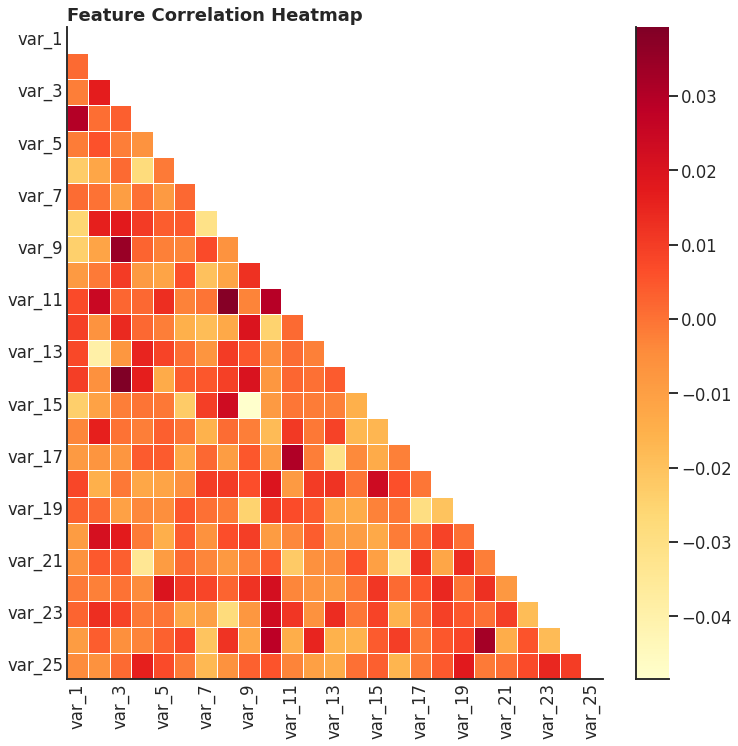

In [8]:
#hide_input
df_corr = pd.DataFrame(X_train, columns=list(df_X)).corr()
mask_ut = np.triu(np.ones(df_corr.shape)).astype(bool)

with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_corr,
        linewidths=0.5,
        cmap="YlOrRd",
        mask=mask_ut,
    )
    ax.set_title("Feature Correlation Heatmap", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()
    fig.set_figheight(12)
    fig.set_figwidth(12)

As we can see, the correlation values cover a small range around zero so there isn't any evidence of multi-collinearity and we don't need select independent variables in order to interpret the best-fit coefficients. Note that this is specific to the dataset we are using here and is very unlikely in a real dataset.

Below, we'll show the mean, standard deviation and variance of each of the independent variables in the training data

In [9]:
##hide_input
d_ranges = {}
d_avgs = {
    f"{f}__{split_type}__mean": val
    for X_split, split_type in zip([X_train, X_test], ["train"])
    for val,f in zip(np.mean(X_split, axis=0).tolist(), list(df_X)[:-1])
}
d_stds = {
    f"{f}__{split_type}__std": val
    for X_split, split_type in zip([X_train, X_test], ["train"])
    for val,f in zip(np.std(X_split, axis=0).tolist(), list(df_X)[:-1])
}
d_vars = {
    f"{f}__{split_type}__var": val
    for X_split, split_type in zip([X_train, X_test], ["train"])
    for val,f in zip(np.var(X_split, axis=0).tolist(), list(df_X)[:-1])
}
d_ranges.update(d_avgs)
d_ranges.update(d_stds)
d_ranges.update(d_vars)

df_ranges = pd.DataFrame.from_dict(
    d_ranges,
    orient="index",
).rename(columns={0: "Value"}).reset_index()
df_ranges[["Column", "Split", "Statistic"]] = df_ranges["index"].str.split("__", expand=True)
df_ranges = df_ranges[["Column", "Split", "Statistic", "Value"]]
df_ranges_pivoted = df_ranges.pivot(index="Column", columns=["Statistic"], values="Value")
display(df_ranges_pivoted.style.format("{:,.5f}").set_caption("Stats for Training Data"))

Statistic,mean,std,var
Column,,,
var_1,0.01168,0.98933,0.97877
var_10,0.00622,1.00519,1.01041
var_11,0.00403,0.99770,0.99541
var_12,-0.02262,0.99986,0.99972
var_13,0.02241,1.01269,1.02554
var_14,-0.01230,0.99987,0.99974
var_15,-0.01553,1.00688,1.01381
var_16,-0.01859,1.00160,1.00319
var_17,-0.00405,0.99642,0.99285


We can see that each of the independent variables in the training data has a mean of zero and a standard deviation of close to 1. This is a consequence of the dataset that we have created here. In more realistic use-cases, this is not the case and so we would have to, for example, standardize the data (independent variables) before performing linear regression. Some machine learning models perform better with such pre-processed data than on raw data and some others required it. This pre-processing is particularly helpful when trying to interpret the weights, after training is completed, since this isn't possible if each of the independent variables covers a different range from the others.

We can make use of `scikit-learn`'s `Pipeline` class to chain together the standardization and linear regression steps in order to optimize the weights and bias. Once this training step is completed, the regression step of the pipeline will be set to the best coefficients and bias. Recall that these were defined in the `__init__` method of the custom Python class and then updated during training in `.fit()`. After training is completed, their values in the class are those at the end of the gradient descent process. Calling `.predict()` after `.fit()` ensures that we make a prediction using the best-fit values found during training. After `.fit()` has completed, any subsequent call to `.predict()` will make a prediction using the best-fit values found during training.

In this way, after training, we will use this pipeline with best-fit values for coefficients and bias to make a prediction on the test data

In [10]:
pipe_manual = Pipeline(
    [
        ("ss", StandardScaler()),
        ("reg", LinearRegressionWithGradientDescent(100, 0.05, None)),
    ]
)
pipe_manual.fit(X_train, y_train)
y_pred_manual = pipe_manual.predict(X_test)

### Checking that the algorithm is working correctly - Examine the cost function

We are keeping track of the objective (or cost) function (*MSE*) at each iteration. After training is completed, we can access the cost function evoluton by iteration, or training history. Below, we'll extract the cost function for each iteration

In [11]:
df_cost = pd.DataFrame.from_records(pipe_manual.named_steps["reg"].cost_func_)

The first 10 rows of the cost function evolution by iteration are shown below

In [12]:
#hide_input
display(df_cost.head(10).style.set_caption("First 10 rows of Cost Function"))

,iteration,cost
0,0,24307.979855
1,1,22031.332903
2,2,19976.771709
3,3,18122.554856
4,4,16449.076952
5,5,14938.658014
6,6,13575.353707
7,7,12344.784339
8,8,11233.980775
9,9,10231.245573


Plot the full cost-function training history with and without a tolerance threshold

In [13]:
pipe_manual_tol = Pipeline(
    [
        ("ss", StandardScaler()),
        ("reg", LinearRegressionWithGradientDescent(100, 0.05, 30)),
    ]
)
pipe_manual_tol.fit(X_train, y_train)
df_cost_tol = pd.DataFrame.from_records(pipe_manual_tol.named_steps["reg"].cost_func_)

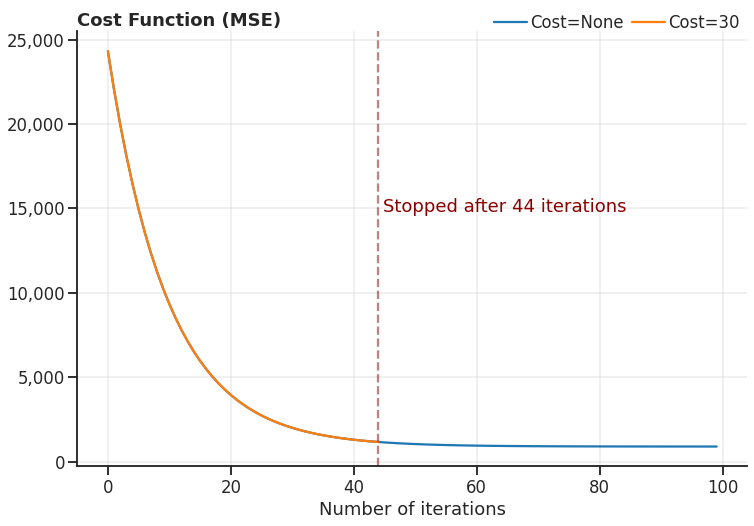

In [14]:
#hide_input
with sns.axes_style("ticks"):
    ax = sns.lineplot(
        x="iteration",
        y="cost",
        hue="tol",
        data=pd.concat([df_cost.assign(tol="Cost=None"), df_cost_tol.assign(tol=f"Cost={30}")], ignore_index=True),
    )
    ax.set_title(
        "Cost Function (MSE)",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(None)
    ax.grid(color="lightgrey", alpha=0.45)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,}'.format(int(x))))
    ax.legend(
        ncol=2,
        loc="upper left",
        bbox_to_anchor=(0.6, 1.075),
        frameon=False,
        handletextpad=0.2,
        columnspacing=0.5,
    )
    ax.legend_.set_title(None)
    line = ax.axvline(
        df_cost_tol.set_index("iteration")["cost"].idxmin(),
        color="darkred",
        ls="--",
        alpha=0.5,
    )
    ax.annotate(
        f"Stopped after {df_cost_tol.set_index('iteration')['cost'].idxmin()} iterations",
        xy=(df_cost_tol.set_index("iteration")["cost"].idxmin(), 0),
        xytext=(5, 250),
        textcoords="offset points",
        color=line.get_color(),
    )
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(12)

The cost function is decreasing as the number of iterations is increased. This is the behaviour we expected so it is reassuring to see this exhibited from our manual implementation of the algorithm.

If gradient descent is performing efficiently, then the cost function should be decreasing after each iteration. We can clearly see that, without the tolerance threshold, we have specified too many iterations. We only needed approximately 60 iterations to minimize the gradient. If the gradient descent algorithm can no longer decrease, the cost function will be constant and is said to have converged. We can see this convergence starting after approximately 60 iterations for our synthetic dataset and for the choice of learning rate (0.05) and without a MSE stopping threshold. The stopping criteria threshold we specified cutoff the algorithm after approximately 45 iterations. So, for this learning rate, we should decrease the number of iterations (without a stopping tolerance) or adjust the stopping tolerance to capture approximately 15 more iterations.

If the cost function is increasing with every iteration, then this might point to a poor choice of initial learning rate. As mentioned earlier, if the learning rate is too high then the algorithm might never reach a minimum and it could just be jumping along the curve in the direction of maximizing the gradient which is not the intended behaviour. The curve won't show convergence of the cost function. Luckily, this isn't the case here so we have atleast picked a reasonable starting value for the learning rate.

### Displaying the predicted values and Best-fit Weights (Coefficients) and Bias

Our custom linear regression model's first 10 predictions of the test split are shown below, compared to the corresponding true values

In [15]:
display(
    pd.DataFrame(X_test, columns=list(df_X)).head(10).merge(
        pd.Series(y_test, name="target").head(10).to_frame().merge(
            pd.Series(y_pred_manual,name="predicted_target",).head(10).to_frame(),
            left_index=True,
            right_index=True,
        ),
        left_index=True,
        right_index=True,
    ).style.set_caption("First 10 observations and known and preducted target values of test split")
)

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,target,predicted_target
0,-1.923454,-1.796301,-0.982786,0.457604,-0.104491,1.795717,-0.186553,-0.880441,-0.610919,0.985903,0.119960,0.532591,-0.872828,0.624335,1.051898,-0.203395,1.235361,0.028513,-0.073853,-1.742632,0.233739,-0.926359,-1.407668,0.992290,-0.694696,212.514966,173.344885
1,-1.056531,-0.747208,0.454180,0.924427,1.805070,-0.110764,-0.163229,1.110975,0.029911,-0.764750,0.690778,1.526860,-1.187208,0.102705,0.827845,-1.044570,-1.173953,0.810510,-1.910594,-0.033122,0.540827,0.001170,-1.264303,0.768591,-0.293051,52.367652,36.894715
2,-1.042418,-0.821429,-0.062885,-0.148327,-1.000657,0.516871,0.076788,-0.224269,-0.117229,0.004950,0.629484,-0.868521,-0.043359,0.109846,-0.027850,-2.306467,1.833603,-2.058016,-0.711670,-0.380086,0.202176,-0.429341,0.523285,-0.030454,-0.526949,-163.179868,-195.917084
3,-0.046920,1.118856,1.625911,-0.511468,0.207604,0.361096,-2.121240,0.077040,-0.344934,0.010806,0.682866,1.131704,1.917818,1.344261,0.888553,0.375325,0.810015,-0.376201,-0.538603,1.010214,-0.969557,0.591528,0.583891,-0.888560,0.349702,97.391584,70.191637
4,0.047814,0.759223,-0.084645,-0.771253,0.460726,1.139622,0.185418,0.715470,0.344126,-0.293447,0.442763,0.089221,-0.923057,-1.508122,-0.145563,1.421391,1.137941,0.005176,2.545589,-0.442619,0.970858,-1.854820,1.103134,0.186033,1.350449,249.593456,207.121306
5,2.139370,0.961131,-1.544328,-0.512599,-0.069124,-1.335064,-1.098256,0.341811,-0.390806,-1.100419,-1.465510,1.367418,-1.404622,-0.025031,0.389392,0.352283,0.567158,-0.429782,-0.658122,-0.698537,0.040165,-1.985189,-0.525582,0.487182,-0.917951,-73.027802,-87.834292
6,1.655406,1.283448,-0.241465,0.503443,-0.297215,-0.315656,1.855960,-0.625804,0.945834,-1.196963,0.998408,-0.087789,-0.328202,-0.264955,-0.077038,1.217371,1.645096,0.316373,-1.244701,0.105713,1.606789,0.721503,0.842319,0.225852,0.873367,106.233229,112.477617
7,-0.907854,0.295983,0.607493,1.665750,0.511770,-0.936718,-0.395667,1.304642,-0.413647,1.597039,0.378173,0.716501,0.366916,-2.083366,1.314320,-1.469228,1.460093,-1.493714,-2.354702,0.116064,0.823188,0.392936,0.611410,1.485290,0.053949,-80.514153,-67.583225
8,0.962547,1.189217,0.122271,-0.255375,-2.325202,-0.134592,0.828324,-0.705864,0.427568,2.807401,0.202110,1.595346,-0.535842,0.170101,0.189906,1.543387,0.807549,-1.120124,0.354840,-0.507901,-1.177085,-1.986059,0.584541,-0.459629,-0.234898,72.670844,39.427636
9,0.090098,-0.697002,-0.900997,-1.232217,0.299003,-0.068079,0.072387,-1.700154,-0.001606,-1.233060,0.641564,0.964712,-0.983009,0.747980,-0.257779,-0.402535,-1.578612,0.582391,1.595396,0.979283,-0.408286,-0.591740,-0.018303,1.429989,2.591537,173.832368,96.837718


### Compare Scoring Performance to `scikit-learn`'s implementations

We can similarly make predictions using the `LinearRegression()` module offered by `scikit-learn`, which is based on the [least squares minimization approach](https://en.wikipedia.org/wiki/Linear_least_squares)

In [16]:
pipe_builtin = Pipeline(
    [
        ("ss", StandardScaler()),
        ("reg", LinearRegression()),
    ]
)
pipe_builtin.fit(X_train, y_train)
y_pred_builtin = pipe_builtin.predict(X_test)

We can repeat this process with the `scikit-learn` `SGDRegressor()` module (using the same number of iterations as was used in our manual implementation here), which uses a variant of gradient descent called stochastic gradient descent explained [here](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/ch04.html)

In [17]:
pipe_builtin_sgd = Pipeline(
    [
        ("ss", StandardScaler()),
        ("reg", SGDRegressor(max_iter=100)),
    ]
)
pipe_builtin_sgd.fit(X_train, y_train)
y_pred_builtin_sgd = pipe_builtin_sgd.predict(X_test)

First, we can compare the best weights (coefficients) determined by our custom linear regression model after gradient descent has completed and the two built-in versions

In [18]:
#collapse
df_coefs = (
    pd.Series(
        pipe_manual.named_steps["reg"].w,
        name="best_coefficient",
        index=list(df_X)
    ).to_frame().assign(best_bias=pipe_manual.named_steps["reg"].b).sort_values(
        by=["best_coefficient"], ascending=False
    ).reset_index().rename(columns={"index": "independent_variable"})
)

df_coefs_builtin_lr = (
    pd.Series(
        pipe_builtin.named_steps["reg"].coef_,
        name="best_coefficient_lr",
        index=list(df_X)
    ).to_frame().assign(
        best_bias_lr=pipe_builtin.named_steps["reg"].intercept_
    ).sort_values(
        by=["best_coefficient_lr"], ascending=False
    ).reset_index().rename(columns={"index": "independent_variable"})
)

df_coefs_builtin_sgd = (
    pd.Series(
        pipe_builtin_sgd.named_steps["reg"].coef_,
        name="best_coefficient_sgd",
        index=list(df_X)
    ).to_frame().assign(
        best_bias_sgd=pipe_builtin_sgd.named_steps["reg"].intercept_[0]
    ).sort_values(
        by=["best_coefficient_sgd"], ascending=False
    ).reset_index().rename(columns={"index": "independent_variable"})
)

coef_cols = ["best_coefficient", "best_coefficient_lr", "best_coefficient_sgd"]
replace_dict = {
    "best_coefficient_sgd": "sgd",
    "best_coefficient_lr": "lr",
    "best_coefficient": "manual",
}

df_coefs_all = df_coefs.merge(
    df_coefs_builtin_lr,
    on="independent_variable"
).merge(
    df_coefs_builtin_sgd,
    on="independent_variable",
).set_index("independent_variable")
df_coefs_all_reshaped = df_coefs_all[coef_cols].unstack().reset_index().rename(
    columns={"level_0": "model", 0: "value"}
)
df_coefs_all_reshaped["model"] = df_coefs_all_reshaped["model"].map(replace_dict)

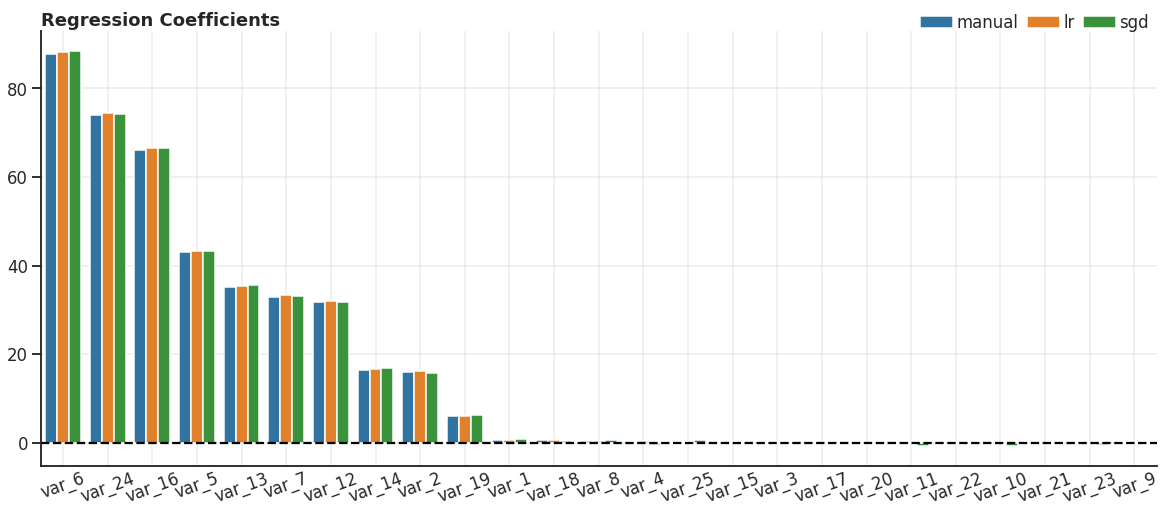

In [19]:
#hide_input
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="value",
        x="independent_variable",
        hue="model",
        data=df_coefs_all_reshaped,
    )
    ax.set_title("Regression Coefficients", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.grid(color="lightgrey", alpha=0.45)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="center")
    ax.xaxis.set_tick_params(length=0)
    ax.axhline(y=0, c="k", ls="--")
    ax.legend(
        ncol=3,
        loc="upper left",
        bbox_to_anchor=(0.775, 1.075),
        frameon=False,
        handletextpad=0.2,
        columnspacing=0.5,
    )
    ax.legend_.set_title(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(20)

For all three linear regression models, we can see that nine of these independent variables have an order of magnitude larger coefficient than the others. This is plausible since, when generating the synthetic dataset, we indicated that 10 independent variables should be useful for predicting the target variable.

Generally the coefficients from the built-in implementation of linear regression using gradient descent, with the specific choice of learning rate used here (0.05), shows good agreement with the two built-in versions. Recall that the same number of iterations was specified for the manual implementation and built-in version of stochastic gradient descent.

As mentioned earlier, this custom implementation does not track the individual weights (coefficients) and bias per iteration. So, we cannot access these after they are learnt using the training data but we can access the best coefficients and bias that are updated after the final iteration is completed.

Next, we show a comparison of two scoring metrics on predictions of data not seen during the process of determining the weights and bias (i.e. during training) using our custom implementation of the linear regression class (relying on gradient descent) compared to the `scikit-learn`'s implementations explored above

In [20]:
#hide_input
d_scores = {
    "R^2__manual": r2_score(y_test, y_pred_manual),
    "R^2_LR__built_in": r2_score(y_test, y_pred_builtin),
    "R^2_SGD__built_in": r2_score(y_test, y_pred_builtin_sgd),
    "MSE__manual": mean_squared_error(y_test, y_pred_manual),
    "MSE_LR__built_in": mean_squared_error(y_test, y_pred_builtin),
    "MSE_SGD__built_in": mean_squared_error(y_test, y_pred_builtin_sgd),
}
df_scores = pd.DataFrame.from_dict(
    d_scores, orient="index"
).reset_index().rename(columns={0: "OOS Score"})
df_scores[["metric", "algorithm"]] = df_scores["index"].str.split("__", expand=True)
df_scores[["metric", "algorithm"]] = df_scores[["metric", "algorithm"]].apply(
    lambda x: x.str.replace("_", "-"),
    axis=1
)
df_scores = df_scores.drop(columns=["index"])[["metric", "algorithm", "OOS Score"]]
display(
    df_scores.style.format("{:,.6f}", subset=["OOS Score"]).set_caption("Performance Comparison")
)

,metric,algorithm,OOS Score
0,R^2,manual,0.962056
1,R^2-LR,built-in,0.962041
2,R^2-SGD,built-in,0.961891
3,MSE,manual,909.425659
4,MSE-LR,built-in,909.793066
5,MSE-SGD,built-in,913.381884


As we can see, the results are quite encouraging as the naive approach compares favourably to the versions of linear regression models offered by `scikit-learn`. Ofcourse, efficiency will likely be truly challenged on larger and more realistic datasets, but that is beyond the current scope.

### HyperParameter Tuning for the Custom Linear Regression Implementation

It is also possible to tune hyper-parameters - learning rate, number of iterations and tolerance - that our custom implementation exposes to the user. We can do this, for example, by defining a grid of values, all combinations of which will be injected into the class before training and making predictions on held-out data. A simple grid across learning rate and number of iterations is shown below

In [21]:
params_grid = {
    "reg__num_iterations": [20, 50, 100, 500, 1_000, 2_000],
    "reg__learning_rate": [0.05, 0.01, 0.005, 0.001],
}

Rather than scoring predictions on a single test split, we can use cross-validation to create multiple divisions of the training data, each with its own training and hold-out split, and score the predictions on each such hold-out split. Since the custom linear regressor class follows the `scikit-learn` API, we can make use `GridSearchCV()` to perform this tuning. We'll use 5-fold cross-validation, choose *MSE* as the scoring metric and use multi-core computing to have each instance of the custom linear regression class scored in parallel as shown below

In [22]:
%%time
gs = GridSearchCV(
    pipe_manual,
    param_grid=params_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
    n_jobs=-1,
)
_ = gs.fit(X_train, y_train)

CPU times: user 22.2 s, sys: 1min 27s, total: 1min 49s
Wall time: 29.5 s


The scores of the predictions on each of the training and hold-out (or validation) sub-splits of the overall training data are shown below

In [23]:
#hide_input
df_gs_cv_scores = pd.DataFrame(gs.cv_results_)[
    [f"param_reg__{p}" for p in ["learning_rate", "num_iterations"]]
    + ["mean_test_score", "std_test_score", "mean_train_score", "std_train_score"]
]
df_gs_cv_scores["mean_train_score"] = df_gs_cv_scores["mean_train_score"] * -1
df_gs_cv_scores["mean_test_score"] = df_gs_cv_scores["mean_test_score"] * -1
df_gs_cv_scores = df_gs_cv_scores.sort_values(by=["mean_test_score"], ascending=True)
display(
    df_gs_cv_scores.style.format(
        "{:,.2f}",
        subset=[
            "mean_test_score",
            "std_test_score",
            "mean_train_score",
            "std_train_score",
        ]
    ).set_caption("Summary of HyperParameter Tuning with Grid Search")
)

,param_reg__learning_rate,param_reg__num_iterations,mean_test_score,std_test_score,mean_train_score,std_train_score
17,0.005000,2000,894.74,48.03,886.59,12.08
10,0.010000,1000,894.74,48.03,886.59,12.08
11,0.010000,2000,894.74,48.04,886.59,12.08
3,0.050000,500,894.74,48.04,886.59,12.08
4,0.050000,1000,894.74,48.04,886.59,12.08
5,0.050000,2000,894.74,48.04,886.59,12.08
2,0.050000,100,895.55,47.48,887.64,12.09
9,0.010000,500,895.76,47.45,887.87,12.09
16,0.005000,1000,895.79,47.44,887.90,12.09
1,0.050000,50,"1,044.48",47.50,"1,035.43",12.18


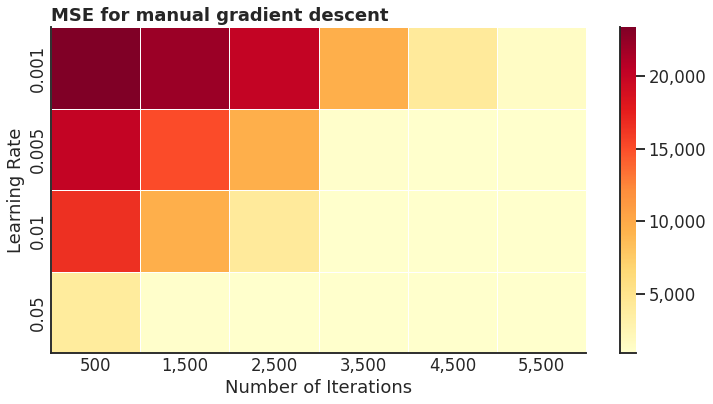

In [24]:
#hide_input
with sns.axes_style("ticks"):
    comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
    ax = sns.heatmap(
        data=df_gs_cv_scores.pivot(
            index="param_reg__learning_rate",
            columns=["param_reg__num_iterations"],
            values="mean_test_score"
        ),
        linewidths=0.5,
        cmap="YlOrRd",
        linecolor="white",
        cbar_kws={'format':comma_fmt}
    )
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x*1000)))
    ax.set_title("MSE for manual gradient descent", loc="left", fontweight="bold")
    ax.set_xlabel("Number of Iterations")
    ax.set_ylabel("Learning Rate")
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(12)

As we can see, for this particular dataset and using the choices of hyper-parameter values specified above for our custom gradient-descent-based linear regression class, higher learning rates (0.01 to 0.05) with a wide range of number of iterations, or low learning rates with 1,000 or more iterations, score better in terms of minimizing the average *MSE* across all the training and validation folds. There is minor evidence of over-fitting, but it is not particularly strong.

## Resources & Further Reading

The scoring performance of this naive implementation of gradient descent is promising, though this was only explored on a small synthetic dataset. The adjustable functionality that is exposed via this custom implementation is restricted to the number of iterations and the learning rate.

The naive version of gradient descent used here is a version of the so-called [mini-batch](https://d2l.ai/chapter_optimization/gd.html#sec-gd) gradient descent. In another version, it is also possible to pass sections of the data to the algorithm. This version is called [stochastic](https://d2l.ai/chapter_optimization/sgd.html#sec-sgd) gradient descent as mentioned earlier, which takes samples of the dataset in each iteration. This is the principle of the second built-in version (`SGDRegressor()` class provided by `scikit-learn`) used here. There is more sophisticated functionality offered by this built-in version. For example
- the learning rate can be specified as a strategy rather than as a simple floating point number as was the case here
- it is also possible to use early-stopping to stop the algorithm running when the *MSE* on a held-out split of the training data stops improving by atleast some minimum threshold that we can specify
  - in our manual implementation, we used all the training data to calculate the MSE for early stopping
- we can stop if no improvement is seen in the validation score after a certain number of iterations
- the dataset used during training can also be shuffled between iterations

See the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn-linear-model-sgdregressor) for more details about using gradient descent for linear regression with this class.

Each flavour of the algorithm has its own advantages and distavantages. Read more about Stochastic gradient descent here ([1](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), [2](https://www.bogotobogo.com/python/scikit-learn/scikit-learn_batch-gradient-descent-versus-stochastic-gradient-descent.php)) to see how it compares to the batch-based approach.